# Visualizing PhysioNet EEG Motor Movement/Imagery Dataset

This notebook demonstrates how to download, load, and visualize EEG data from the PhysioNet EEG Motor Movement/Imagery Dataset.

## Dataset Information

The EEG Motor Movement/Imagery Dataset contains 64-channel EEG data from 109 subjects performing various motor/imagery tasks. The dataset is available at:
https://physionet.org/content/eegmmidb/1.0.0/

**Note**: The dataset uses the EDF format (not MAT), which is common for physiological signals.

## Dataset Details:
- **Subjects**: 109 volunteers
- **Channels**: 64 EEG channels
- **Sampling Rate**: 160 Hz
- **Tasks**: Baseline, motor execution, and motor imagery tasks
- **Format**: EDF (European Data Format)

## Requirements

Before running this notebook, make sure you have the following packages installed:

```bash
pip install numpy matplotlib scipy mne requests
```

These dependencies are also listed in `requirements.txt`.

## 0. Install all Required Libraries

In [6]:
!pip install numpy matplotlib scipy mne requests --quiet

## 1. Import Required Libraries

In [7]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import mne
from pathlib import Path

# Set up plotting style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    # Fall back to default style if seaborn style is not available
    plt.style.use('default')
    print("Note: Using default matplotlib style")
%matplotlib inline

print("Libraries imported successfully!")
print(f"MNE version: {mne.__version__}")

Libraries imported successfully!
MNE version: 1.11.0


## 2. Download EEG Data from PhysioNet

We'll download a sample EDF file from the PhysioNet database. For this example, we'll use Subject 1, Run 1 (baseline task with eyes open).

In [8]:
# Create a directory to store the downloaded data
data_dir = Path('physionet_eeg_data')
data_dir.mkdir(exist_ok=True)

# Define the URL for the EEG file
# Subject 1, Run 1 (baseline, eyes open)
subject = 'S001'
run = 'R01'
filename = f'{subject}{run}.edf'
url = f'https://physionet.org/files/eegmmidb/1.0.0/{subject}/{filename}'

file_path = data_dir / filename

# Download the file if it doesn't exist
if not file_path.exists():
    print(f"Downloading {filename}...")
    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        
        with open(file_path, 'wb') as f:
            f.write(response.content)
        
        print(f"Download complete! File saved to {file_path}")
    except requests.exceptions.HTTPError as e:
        if e.response.status_code == 404:
            print(f"Error: File not found (404). The file may have been moved or the URL is incorrect.")
        elif e.response.status_code == 403:
            print(f"Error: Access denied (403). You may not have permission to access this file.")
        else:
            print(f"HTTP Error {e.response.status_code}: {e}")
        print("\nAlternative: You can manually download the file from:")
        print(url)
        print(f"And place it in the '{data_dir}' directory")
        raise
    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")
        print("This may be due to network issues or firewall restrictions.")
        raise
else:
    print(f"File already exists: {file_path}")

Download complete! File saved to physionet_eeg_data\S001R01.edf


## 3. Load EEG Data

We'll use the MNE-Python library to load and process the EDF file. MNE is a powerful library specifically designed for EEG/MEG data analysis.

In [9]:
# Load the EDF file
# Note: Using preload=False initially to check metadata without loading all data
# For large files, this saves memory. We'll load data as needed later.
try:
    raw = mne.io.read_raw_edf(file_path, preload=False, verbose=False)
    print("EEG data file opened successfully!")
    print(f"\nDataset Information:")
    print(f"  Number of channels: {len(raw.ch_names)}")
    print(f"  Sampling rate: {raw.info['sfreq']} Hz")
    print(f"  Duration: {raw.times[-1]:.2f} seconds")
    print(f"  Total samples: {len(raw.times)}")
    print(f"\nFirst 10 channel names: {raw.ch_names[:10]}")
    
    # Load the data into memory now (for this small example file it's fine)
    # For larger files, consider loading only specific time segments
    raw.load_data()
    print("\nData loaded into memory.")
    
    # Clean channel names by removing trailing dots/periods
    # PhysioNet EEG data has channel names like 'Fc5.', 'C3..', etc.
    # We need to clean them to match standard montage names
    rename_dict = {old: old.rstrip('.') for old in raw.ch_names}
    raw.rename_channels(rename_dict)
    
    # Set standard montage for electrode positions (needed for topographic plots)
    # match_case=False allows matching 'Fc5' to 'FC5' in the montage
    # on_missing='ignore' skips channels not found in the montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='ignore', match_case=False)
    print("Electrode montage set successfully.")
except Exception as e:
    print(f"Error loading EEG data: {e}")
    raise

EEG data file opened successfully!

Dataset Information:
  Number of channels: 64
  Sampling rate: 160.0 Hz
  Duration: 60.99 seconds
  Total samples: 9760

First 10 channel names: ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..']
Reading 0 ... 9759  =      0.000 ...    60.994 secs...

Data loaded into memory.


## 4. Visualize EEG Channels

### 4.1 Plot Multiple Channels - Time Series View

We'll create a time-series plot showing multiple EEG channels. This gives us an overview of the signal patterns across different brain regions.

Plotting channels: ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.']


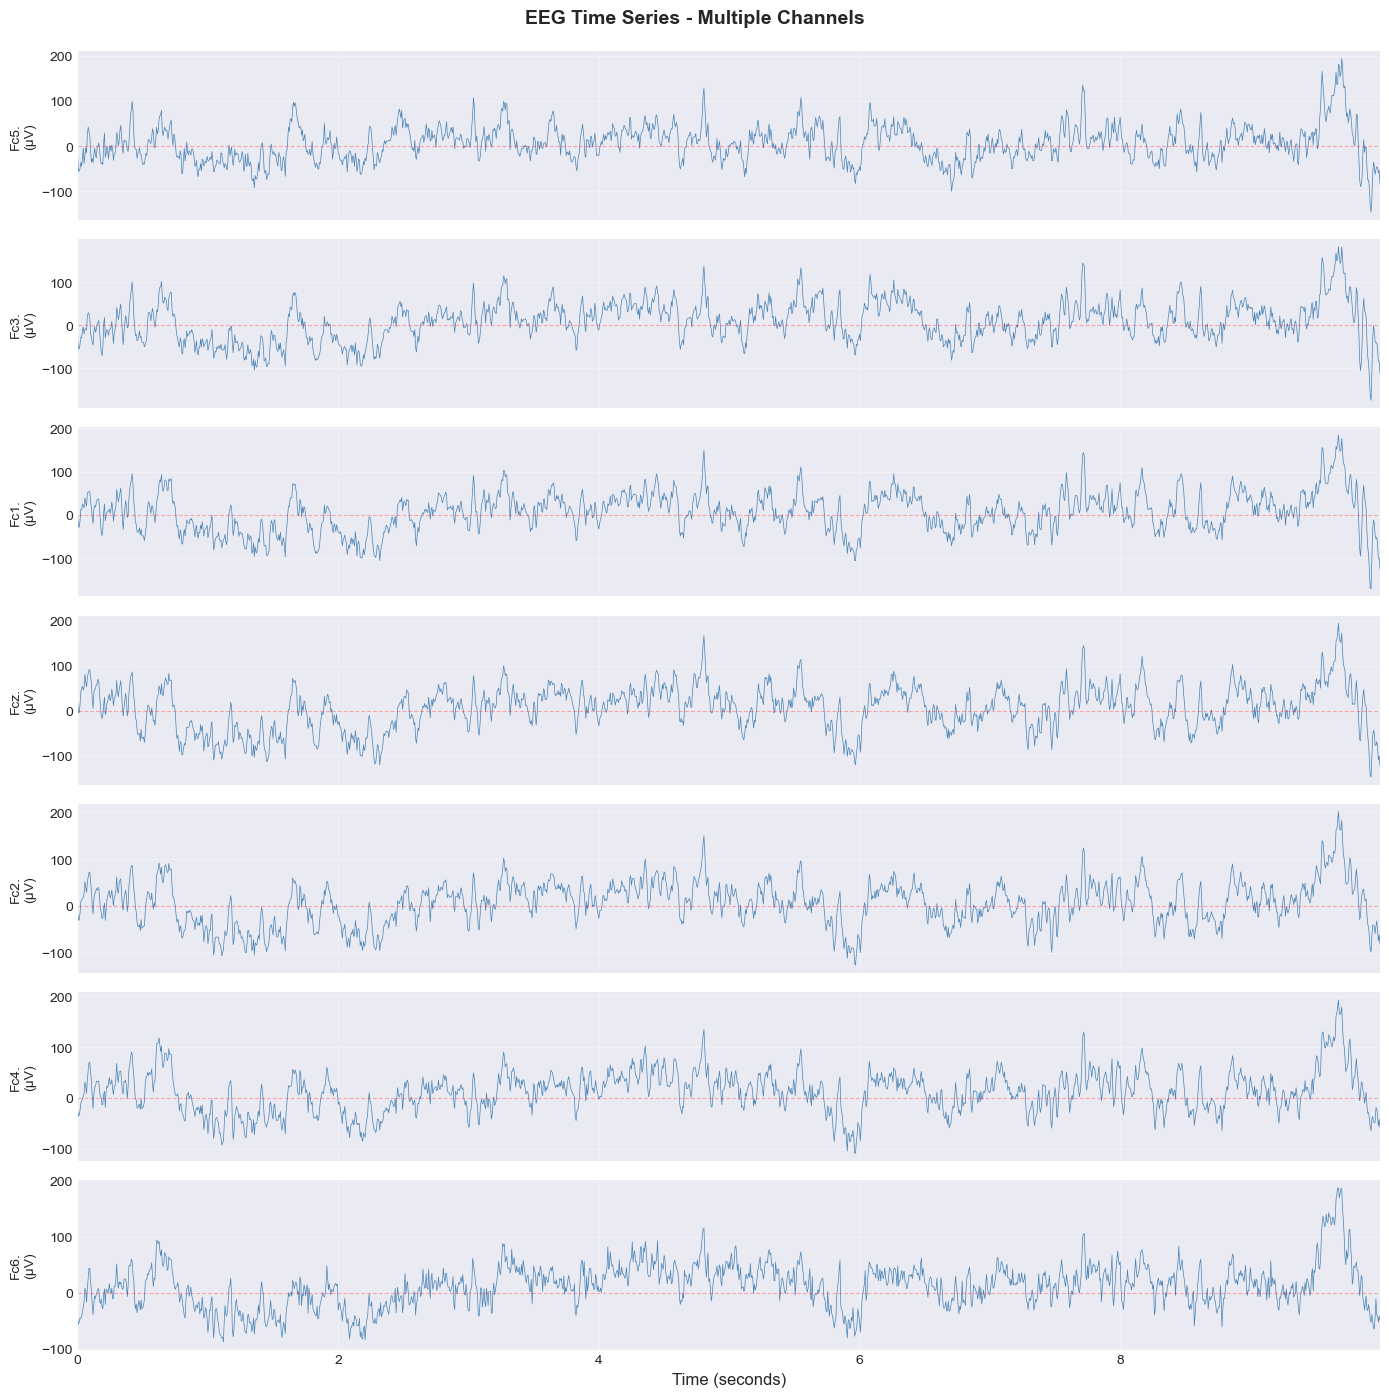


Displayed 10.0 seconds of EEG data from channels: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6.


In [10]:
# Select a subset of channels for visualization
# We'll focus on common EEG channels: Fz, Cz, Pz, Oz (midline channels)
channels_to_plot = ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.']

# Filter to only include channels that exist in the data
available_channels = [ch for ch in channels_to_plot if ch in raw.ch_names]

if not available_channels:
    # If specified channels are not available, use the first 7 channels
    available_channels = raw.ch_names[:7]

print(f"Plotting channels: {available_channels}")

# Extract data for selected channels (first 10 seconds)
duration = 10.0  # seconds
start_time = 0.0
end_time = start_time + duration

# Get data
data, times = raw.get_data(picks=available_channels, 
                           start=int(start_time * raw.info['sfreq']),
                           stop=int(end_time * raw.info['sfreq']),
                           return_times=True)

# Convert from Volts to microvolts for better readability
data_uv = data * 1e6

# Create the plot
fig, axes = plt.subplots(len(available_channels), 1, 
                         figsize=(14, 2*len(available_channels)), 
                         sharex=True)

if len(available_channels) == 1:
    axes = [axes]

for idx, (ax, ch_name) in enumerate(zip(axes, available_channels)):
    ax.plot(times, data_uv[idx], linewidth=0.5, color='steelblue')
    ax.set_ylabel(f'{ch_name}\n(µV)', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(times[0], times[-1])
    
    # Add zero line for reference
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.3, linewidth=0.8)

axes[-1].set_xlabel('Time (seconds)', fontsize=12)
fig.suptitle('EEG Time Series - Multiple Channels', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\nDisplayed {duration} seconds of EEG data from channels: {', '.join(available_channels)}")

### 4.2 Plot Single Channel with Detailed View

Let's examine a single channel in more detail to see the EEG waveform characteristics.

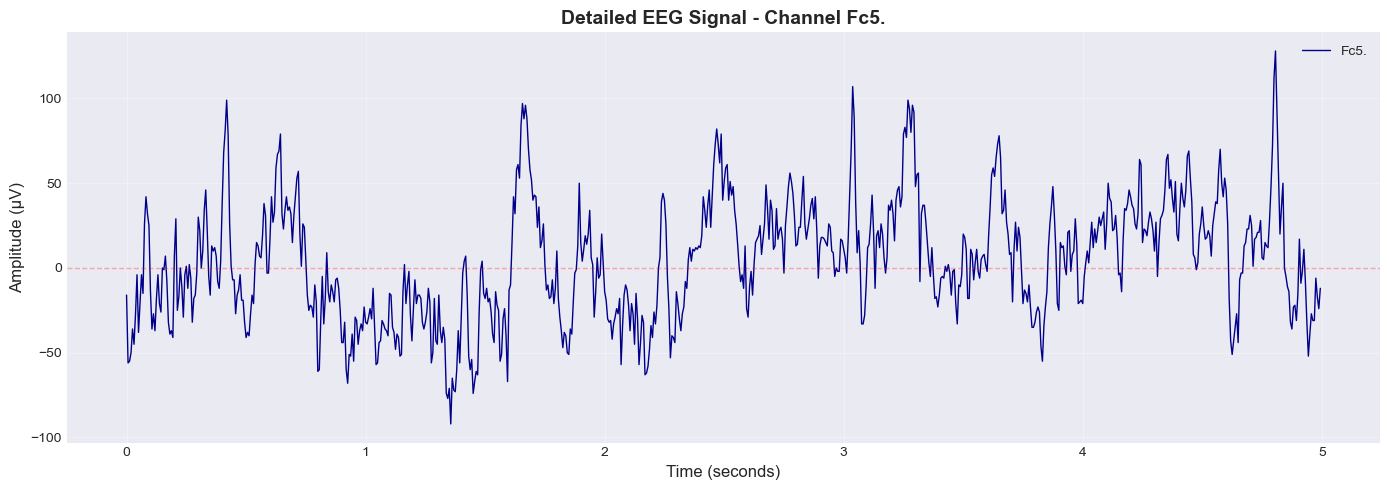


Channel Fc5. Statistics:
  Mean: 4.03 µV
  Std Dev: 35.06 µV
  Min: -92.00 µV
  Max: 128.00 µV
  Range: 220.00 µV


In [11]:
# Select a single channel for detailed visualization
single_channel = available_channels[0]
channel_idx = raw.ch_names.index(single_channel)

# Get 5 seconds of data
duration = 5.0
data_single, times_single = raw.get_data(picks=[single_channel],
                                         start=0,
                                         stop=int(duration * raw.info['sfreq']),
                                         return_times=True)

# Convert to microvolts
data_single_uv = data_single[0] * 1e6

# Create detailed plot
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(times_single, data_single_uv, linewidth=1.0, color='darkblue', label=single_channel)
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Amplitude (µV)', fontsize=12)
ax.set_title(f'Detailed EEG Signal - Channel {single_channel}', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.3, linewidth=1.0)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nChannel {single_channel} Statistics:")
print(f"  Mean: {np.mean(data_single_uv):.2f} µV")
print(f"  Std Dev: {np.std(data_single_uv):.2f} µV")
print(f"  Min: {np.min(data_single_uv):.2f} µV")
print(f"  Max: {np.max(data_single_uv):.2f} µV")
print(f"  Range: {np.max(data_single_uv) - np.min(data_single_uv):.2f} µV")

### 4.3 Power Spectral Density (PSD) Plot

Analyze the frequency content of the EEG signals. This helps identify dominant brain rhythms (delta, theta, alpha, beta, gamma).

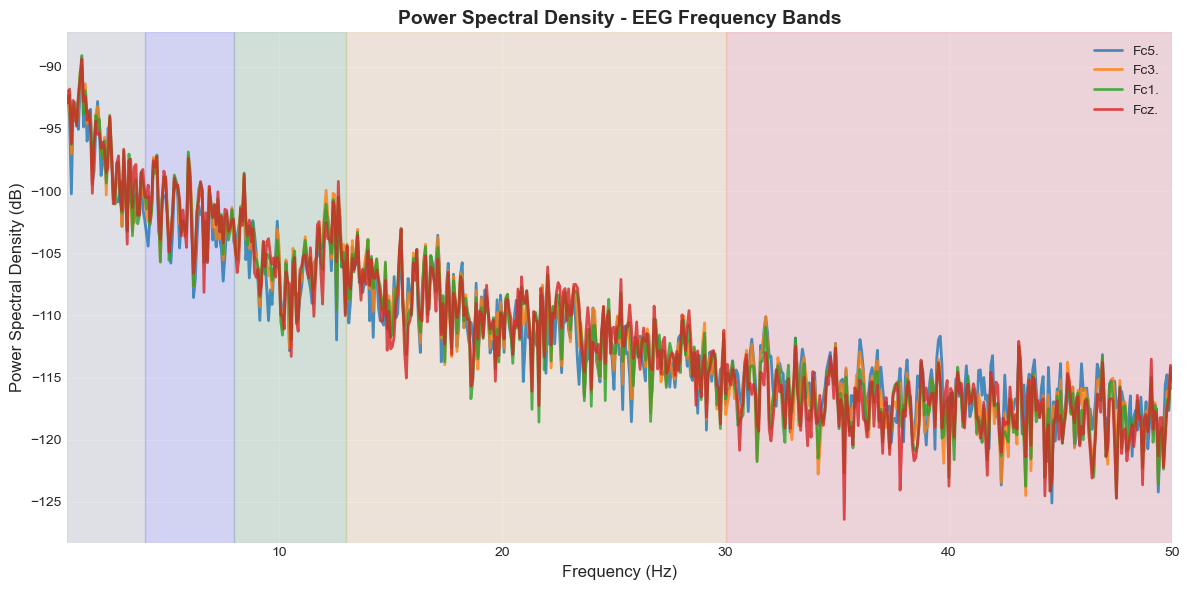


EEG Frequency Bands:
  Delta (0.5-4 Hz): Deep sleep
  Theta (4-8 Hz): Drowsiness, meditation
  Alpha (8-13 Hz): Relaxed, eyes closed
  Beta (13-30 Hz): Active thinking, focus
  Gamma (30-50 Hz): High-level cognitive processing


In [12]:
# Compute power spectral density
fig, ax = plt.subplots(figsize=(12, 6))

# Select channels for PSD analysis
psd_channels = available_channels[:4]  # Use first 4 channels

# Compute and plot PSD for each channel
for ch in psd_channels:
    # Get PSD using Welch's method
    spectrum = raw.compute_psd(picks=[ch], fmin=0.5, fmax=50, method='welch', verbose=False)
    psds, freqs = spectrum.get_data(return_freqs=True)
    
    # Convert to dB
    psds_db = 10 * np.log10(psds[0])
    
    ax.plot(freqs, psds_db, linewidth=2, label=ch, alpha=0.8)

# Mark frequency bands
bands = {
    'Delta (0.5-4 Hz)': (0.5, 4, 'gray'),
    'Theta (4-8 Hz)': (4, 8, 'blue'),
    'Alpha (8-13 Hz)': (8, 13, 'green'),
    'Beta (13-30 Hz)': (13, 30, 'orange'),
    'Gamma (30-50 Hz)': (30, 50, 'red')
}

for band_name, (fmin, fmax, color) in bands.items():
    ax.axvspan(fmin, fmax, alpha=0.1, color=color)

ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Power Spectral Density (dB)', fontsize=12)
ax.set_title('Power Spectral Density - EEG Frequency Bands', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim(0.5, 50)

plt.tight_layout()
plt.show()

print("\nEEG Frequency Bands:")
print("  Delta (0.5-4 Hz): Deep sleep")
print("  Theta (4-8 Hz): Drowsiness, meditation")
print("  Alpha (8-13 Hz): Relaxed, eyes closed")
print("  Beta (13-30 Hz): Active thinking, focus")
print("  Gamma (30-50 Hz): High-level cognitive processing")

### 4.4 Topographic Map (Scalp Topography)

Visualize the spatial distribution of EEG activity across the scalp at a specific time point.

In [13]:
# Create a topographic map showing the average signal across a time window
try:
    # Select a time window (e.g., 2-3 seconds)
    tmin, tmax = 2.0, 3.0
    
    # Create evoked object for topographic plotting
    # Average the data over the time window
    times_to_plot = [2.5]  # Middle of the window
    
    # Get the data for all EEG channels
    data_for_topo = raw.get_data(start=int(tmin * raw.info['sfreq']),
                                 stop=int(tmax * raw.info['sfreq']))
    
    # Average over time
    data_avg = np.mean(data_for_topo, axis=1, keepdims=True)
    
    # Create evoked structure for plotting
    info = mne.create_info(ch_names=raw.ch_names, sfreq=raw.info['sfreq'], ch_types='eeg')
    evoked = mne.EvokedArray(data_avg, info, tmin=0)
    
    # Set standard montage for electrode positions
    montage = mne.channels.make_standard_montage('standard_1020')
    evoked.set_montage(montage, on_missing='ignore')
    
    # Plot topographic map
    fig = evoked.plot_topomap(times=[0], ch_type='eeg', 
                              time_format='',
                              colorbar=True, size=4,
                              title='EEG Topographic Map\n(Average 2-3 seconds)',
                              show=False)
    plt.tight_layout()
    plt.show()
    
    print("Topographic map shows the spatial distribution of EEG activity across the scalp.")
    print("Warmer colors indicate higher amplitude, cooler colors indicate lower amplitude.")
    
except Exception as e:
    print(f"Note: Topographic plotting requires proper electrode positions.")
    print(f"Error: {e}")
    print("This is expected if the electrode positions are not standard or missing.")

Note: Topographic plotting requires proper electrode positions.
Error: Evoked.plot_topomap() got an unexpected keyword argument 'title'
This is expected if the electrode positions are not standard or missing.


### 4.5 Phase Lag Index (PLI) Connectivity Heatmaps

**Phase Lag Index (PLI)** is a connectivity measure that quantifies the statistical interdependence between two EEG signals based on the consistency of their phase difference. Unlike correlation, PLI is insensitive to volume conduction effects (signals spreading through the brain that create spurious correlations).

**Key concepts:**
- PLI values range from 0 to 1
- Higher values indicate stronger phase synchronization between channels
- PLI = 0: No consistent phase relationship
- PLI = 1: Perfect phase locking
- Useful for analyzing functional connectivity between brain regions

We'll calculate PLI connectivity matrices for different conditions and visualize them as heatmaps.

In [ ]:
from scipy.signal import hilbert
import seaborn as sns

def calculate_pli(data1, data2):
    """
    Calculate Phase Lag Index between two signals.
    
    Parameters:
    -----------
    data1, data2 : array
        Input signals (same length)
    
    Returns:
    --------
    pli : float
        Phase Lag Index value (0 to 1)
    """
    # Get analytical signals using Hilbert transform
    analytic1 = hilbert(data1)
    analytic2 = hilbert(data2)
    
    # Get instantaneous phases
    phase1 = np.angle(analytic1)
    phase2 = np.angle(analytic2)
    
    # Calculate phase difference
    phase_diff = phase1 - phase2
    
    # PLI is the absolute value of the mean of the sign of phase differences
    pli = np.abs(np.mean(np.sign(phase_diff)))
    
    return pli

def calculate_connectivity_matrix(raw_data, picks=None, fmin=8, fmax=13):
    """
    Calculate PLI connectivity matrix for all channel pairs.
    
    Parameters:
    -----------
    raw_data : mne.io.Raw
        MNE Raw object containing EEG data
    picks : list or None
        Channel indices to use. If None, uses first 20 channels
    fmin, fmax : float
        Frequency band to filter (default: alpha band 8-13 Hz)
    
    Returns:
    --------
    connectivity_matrix : ndarray
        PLI connectivity matrix (n_channels x n_channels)
    channel_names : list
        Names of channels used
    """
    # Filter data to frequency band of interest
    raw_filtered = raw_data.copy().filter(fmin, fmax, fir_design='firwin', verbose=False)
    
    # Get data
    if picks is None:
        picks = range(min(20, len(raw_filtered.ch_names)))  # Use first 20 channels or all if less
    
    data = raw_filtered.get_data(picks=picks)
    n_channels = len(picks)
    
    # Initialize connectivity matrix
    connectivity_matrix = np.zeros((n_channels, n_channels))
    
    # Calculate PLI for all channel pairs
    for i in range(n_channels):
        for j in range(i+1, n_channels):  # Only upper triangle (symmetric matrix)
            pli_val = calculate_pli(data[i], data[j])
            connectivity_matrix[i, j] = pli_val
            connectivity_matrix[j, i] = pli_val  # Make symmetric
    
    # Set diagonal to 1 (perfect self-connectivity)
    np.fill_diagonal(connectivity_matrix, 1.0)
    
    # Get channel names
    channel_names = [raw_filtered.ch_names[i] for i in picks]
    
    return connectivity_matrix, channel_names

print("PLI calculation functions defined successfully!")

In [ ]:
# Calculate connectivity matrix for the alpha band (8-13 Hz)
print("Calculating PLI connectivity matrix (this may take a minute)...")
connectivity_matrix, channel_names = calculate_connectivity_matrix(raw, picks=range(20), fmin=8, fmax=13)

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))

# Use seaborn for better heatmap visualization
sns.heatmap(connectivity_matrix, 
            xticklabels=channel_names,
            yticklabels=channel_names,
            cmap='YlOrRd',
            vmin=0, vmax=1,
            square=True,
            cbar_kws={'label': 'PLI Value'},
            ax=ax)

ax.set_title('Phase Lag Index (PLI) Connectivity Matrix\\nAlpha Band (8-13 Hz)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('EEG Channels', fontsize=12)
ax.set_ylabel('EEG Channels', fontsize=12)

# Rotate labels for better readability
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.setp(ax.yaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print(f"\\nConnectivity Matrix Statistics:")
print(f"  Mean PLI: {np.mean(connectivity_matrix[np.triu_indices_from(connectivity_matrix, k=1)]):.3f}")
print(f"  Max PLI: {np.max(connectivity_matrix[np.triu_indices_from(connectivity_matrix, k=1)]):.3f}")
print(f"  Min PLI: {np.min(connectivity_matrix[np.triu_indices_from(connectivity_matrix, k=1)]):.3f}")

#### Multi-Condition PLI Comparison

Let's compare PLI connectivity between different conditions. We'll download an additional run (motor imagery task) and compare it with the baseline condition.

In [ ]:
# Download a second run for comparison (Motor imagery: left vs right fist)
run2 = 'R04'  # Run 4 is a motor imagery task
filename2 = f'{subject}{run2}.edf'
url2 = f'https://physionet.org/files/eegmmidb/1.0.0/{subject}/{filename2}'
file_path2 = data_dir / filename2

if not file_path2.exists():
    print(f"Downloading {filename2}...")
    try:
        response = requests.get(url2, timeout=30)
        response.raise_for_status()
        with open(file_path2, 'wb') as f:
            f.write(response.content)
        print(f"Download complete! File saved to {file_path2}")
    except Exception as e:
        print(f"Error downloading file: {e}")
        print("Continuing with single condition analysis...")
        file_path2 = None
else:
    print(f"File already exists: {file_path2}")

# Load the second run if available
if file_path2 and file_path2.exists():
    raw2 = mne.io.read_raw_edf(file_path2, preload=True, verbose=False)
    print(f"\nLoaded {filename2}:")
    print(f"  Duration: {raw2.times[-1]:.2f} seconds")
    print(f"  Channels: {len(raw2.ch_names)}")
    
    # Clean channel names by removing trailing dots/periods
    rename_dict = {old: old.rstrip('.') for old in raw2.ch_names}
    raw2.rename_channels(rename_dict)
    
    # Set standard montage for electrode positions (needed for topographic plots)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw2.set_montage(montage, on_missing='ignore', match_case=False)
    print("Electrode montage set successfully for raw2.")
else:
    raw2 = None
    print("\nSecond condition not available for comparison.")

In [ ]:
# Create multi-panel comparison if second condition is available
if raw2 is not None:
    print("Calculating connectivity matrices for both conditions...")
    
    # Calculate connectivity for both conditions
    conn1, ch_names = calculate_connectivity_matrix(raw, picks=range(20), fmin=8, fmax=13)
    conn2, _ = calculate_connectivity_matrix(raw2, picks=range(20), fmin=8, fmax=13)
    
    # Calculate difference
    conn_diff = conn2 - conn1
    
    # Create three-panel figure
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Panel 1: Baseline (R01)
    sns.heatmap(conn1, 
                xticklabels=ch_names,
                yticklabels=ch_names,
                cmap='YlOrRd',
                vmin=0, vmax=1,
                square=True,
                cbar_kws={'label': 'PLI'},
                ax=axes[0])
    axes[0].set_title('Baseline (Eyes Open)\\nR01', fontsize=12, fontweight='bold')
    
    # Panel 2: Motor Imagery (R04)
    sns.heatmap(conn2,
                xticklabels=ch_names,
                yticklabels=ch_names,
                cmap='YlOrRd',
                vmin=0, vmax=1,
                square=True,
                cbar_kws={'label': 'PLI'},
                ax=axes[1])
    axes[1].set_title('Motor Imagery (L/R Fist)\\nR04', fontsize=12, fontweight='bold')
    
    # Panel 3: Difference (R04 - R01)
    # Use diverging colormap for differences
    max_diff = np.max(np.abs(conn_diff))
    sns.heatmap(conn_diff,
                xticklabels=ch_names,
                yticklabels=ch_names,
                cmap='RdBu_r',
                vmin=-max_diff, vmax=max_diff,
                center=0,
                square=True,
                cbar_kws={'label': 'PLI Difference'},
                ax=axes[2])
    axes[2].set_title('Difference\\n(R04 - R01)', fontsize=12, fontweight='bold')
    
    # Format all subplots
    for ax in axes:
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)
        plt.setp(ax.yaxis.get_majorticklabels(), rotation=0, fontsize=8)
        ax.set_xlabel('Channels', fontsize=10)
        ax.set_ylabel('Channels', fontsize=10)
    
    plt.suptitle('Phase Lag Index (PLI) Connectivity Comparison - Alpha Band (8-13 Hz)',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\\nConnectivity Statistics:")
    print(f"  Baseline mean PLI: {np.mean(conn1[np.triu_indices_from(conn1, k=1)]):.3f}")
    print(f"  Motor Imagery mean PLI: {np.mean(conn2[np.triu_indices_from(conn2, k=1)]):.3f}")
    print(f"  Mean difference: {np.mean(conn_diff[np.triu_indices_from(conn_diff, k=1)]):.3f}")
else:
    print("Second condition not available. Skipping comparison.")

### 4.6 Enhanced Power Spectral Density (PSD) Topographic Maps

**Power Spectral Density (PSD)** represents the power distribution of EEG signals across different frequencies. By visualizing PSD values on a topographic map of the scalp, we can see which brain regions show more activity in specific frequency bands.

**Key concepts:**
- PSD values show the strength of oscillations at different frequencies
- Higher PSD values indicate stronger neural activity in that frequency range
- Different frequency bands (delta, theta, alpha, beta, gamma) are associated with different cognitive states
- Topographic maps show the spatial distribution across the scalp using the 10-20 electrode system

We'll create enhanced topographic maps with:
- Smooth interpolation between electrodes
- Proper head outline showing electrode positions
- Comparison between conditions
- Difference maps highlighting changes

In [ ]:
from mne.viz import plot_topomap

def calculate_band_power_topomap(raw_data, fmin, fmax, picks=None):
    """
    Calculate average power in a frequency band for topographic mapping.
    
    Parameters:
    -----------
    raw_data : mne.io.Raw
        MNE Raw object
    fmin, fmax : float
        Frequency band limits
    picks : list or None
        Channel indices to use
    
    Returns:
    --------
    power_values : ndarray
        Power values for each channel
    """
    # Compute PSD using Welch's method
    spectrum = raw_data.compute_psd(method='welch', fmin=fmin, fmax=fmax, 
                                     n_fft=1024, picks=picks, verbose=False)
    
    # Get power in the frequency band (average across frequencies)
    psds, freqs = spectrum.get_data(return_freqs=True)
    
    # Average power across the frequency band
    power_values = np.mean(psds, axis=1)
    
    return power_values

# Calculate PSD for alpha band in baseline condition
print("Calculating PSD topographic maps...")

# Define frequency bands
bands = {
    'Delta (0.5-4 Hz)': (0.5, 4),
    'Theta (4-8 Hz)': (4, 8),
    'Alpha (8-13 Hz)': (8, 13),
    'Beta (13-30 Hz)': (13, 30)
}

# Create figure with multiple frequency bands
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (band_name, (fmin, fmax)) in enumerate(bands.items()):
    # Calculate power
    power = calculate_band_power_topomap(raw, fmin, fmax)
    
    # Convert to dB for better visualization
    power_db = 10 * np.log10(power)
    
    # Create topographic map
    im, _ = plot_topomap(power_db, raw.info, axes=axes[idx],
                         show=False, cmap='RdYlBu_r',
                         contours=6, sphere=None)
    
    axes[idx].set_title(f'{band_name}\\nBaseline (R01)', fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    cbar.set_label('Power (dB)', fontsize=10)

plt.suptitle('Power Spectral Density (PSD) Topographic Maps\\nSpatial Distribution Across Frequency Bands',
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("PSD topographic maps created successfully!")

#### PSD Comparison Between Conditions

Now let's compare the spatial distribution of alpha band power between baseline and motor imagery conditions.

In [ ]:
if raw2 is not None:
    print("Creating PSD comparison topographic maps...")
    
    # Focus on alpha band for comparison
    fmin, fmax = 8, 13
    
    # Calculate power for both conditions
    power1 = calculate_band_power_topomap(raw, fmin, fmax)
    power2 = calculate_band_power_topomap(raw2, fmin, fmax)
    
    # Convert to dB
    power1_db = 10 * np.log10(power1)
    power2_db = 10 * np.log10(power2)
    
    # Calculate difference
    power_diff = power2_db - power1_db
    
    # Create three-panel comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Determine common color scale for first two panels
    vmin = min(power1_db.min(), power2_db.min())
    vmax = max(power1_db.max(), power2_db.max())
    
    # Panel 1: Baseline
    im1, _ = plot_topomap(power1_db, raw.info, axes=axes[0],
                          show=False, cmap='RdYlBu_r',
                          contours=6, vmin=vmin, vmax=vmax)
    axes[0].set_title('Baseline (Eyes Open)\\nR01', fontsize=12, fontweight='bold')
    cbar1 = plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    cbar1.set_label('Power (dB)', fontsize=10)
    
    # Panel 2: Motor Imagery
    im2, _ = plot_topomap(power2_db, raw2.info, axes=axes[1],
                          show=False, cmap='RdYlBu_r',
                          contours=6, vmin=vmin, vmax=vmax)
    axes[1].set_title('Motor Imagery (L/R Fist)\\nR04', fontsize=12, fontweight='bold')
    cbar2 = plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    cbar2.set_label('Power (dB)', fontsize=10)
    
    # Panel 3: Difference (using diverging colormap)
    max_diff = np.max(np.abs(power_diff))
    im3, _ = plot_topomap(power_diff, raw.info, axes=axes[2],
                          show=False, cmap='RdBu_r',
                          contours=6, vmin=-max_diff, vmax=max_diff)
    axes[2].set_title('Difference\\n(R04 - R01)', fontsize=12, fontweight='bold')
    cbar3 = plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
    cbar3.set_label('Power Difference (dB)', fontsize=10)
    
    plt.suptitle('Alpha Band (8-13 Hz) Power Comparison - Topographic Maps',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\\nAlpha Band Power Statistics:")
    print(f"  Baseline mean: {power1_db.mean():.2f} dB")
    print(f"  Motor Imagery mean: {power2_db.mean():.2f} dB")
    print(f"  Mean difference: {power_diff.mean():.2f} dB")
    
    # Find channels with largest differences
    top_diff_idx = np.argsort(np.abs(power_diff))[-5:][::-1]
    print("\\n  Top 5 channels with largest changes:")
    for i, idx in enumerate(top_diff_idx, 1):
        ch_name = raw.ch_names[idx]
        diff = power_diff[idx]
        print(f"    {i}. {ch_name}: {diff:+.2f} dB")
else:
    print("Second condition not available. Skipping PSD comparison.")

## 5. Interactive Visualization with MNE

MNE provides an interactive browser for exploring EEG data. This is useful for detailed inspection of the signals.

Creating interactive EEG browser...
Note: This visualization works best in local Jupyter notebooks.
If running in a cloud environment, you may see a static image instead.

In the interactive view, you can:
  - Scroll through time
  - Zoom in/out
  - Select/deselect channels
  - Adjust scaling
Using matplotlib as 2D backend.


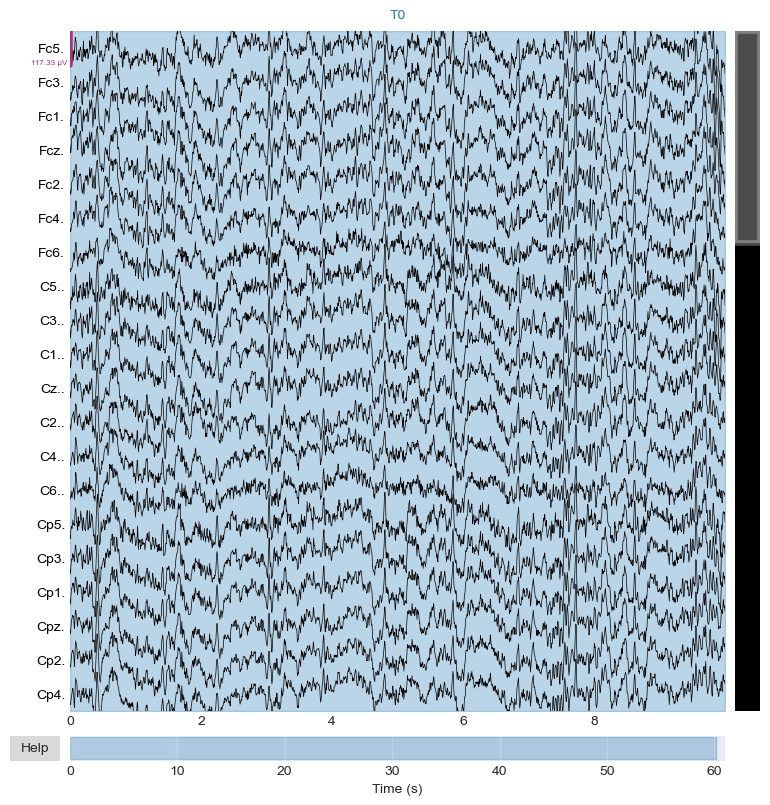

In [14]:
# Note: The interactive plot works best in local Jupyter environments
# It may not display properly in some cloud-based notebooks

print("Creating interactive EEG browser...")
print("Note: This visualization works best in local Jupyter notebooks.")
print("If running in a cloud environment, you may see a static image instead.")
print("\nIn the interactive view, you can:")
print("  - Scroll through time")
print("  - Zoom in/out")
print("  - Select/deselect channels")
print("  - Adjust scaling")

# Create static plot for non-interactive environments
fig = raw.plot(duration=10.0, n_channels=20, scalings='auto', 
               title='EEG Data Browser (First 10 seconds, 20 channels)',
               show=False, block=False)
plt.show()

## 6. Summary Statistics

Let's compute some summary statistics for all channels to get an overview of the data quality and characteristics.

In [15]:
# Get all data
all_data = raw.get_data()

# Convert to microvolts
all_data_uv = all_data * 1e6

# Compute statistics for each channel
print("\nSummary Statistics for All Channels:")
print("=" * 80)
print(f"{'Channel':<15} {'Mean (µV)':<12} {'Std (µV)':<12} {'Min (µV)':<12} {'Max (µV)':<12}")
print("-" * 80)

for idx, ch_name in enumerate(raw.ch_names[:10]):  # Show first 10 channels
    mean_val = np.mean(all_data_uv[idx])
    std_val = np.std(all_data_uv[idx])
    min_val = np.min(all_data_uv[idx])
    max_val = np.max(all_data_uv[idx])
    
    print(f"{ch_name:<15} {mean_val:>11.2f} {std_val:>11.2f} {min_val:>11.2f} {max_val:>11.2f}")

if len(raw.ch_names) > 10:
    print(f"... and {len(raw.ch_names) - 10} more channels")

print("\nOverall Dataset Statistics:")
print(f"  Total recording duration: {raw.times[-1]:.2f} seconds ({raw.times[-1]/60:.2f} minutes)")
print(f"  Number of channels: {len(raw.ch_names)}")
print(f"  Sampling rate: {raw.info['sfreq']} Hz")
print(f"  Total samples per channel: {len(raw.times):,}")
print(f"  Overall mean amplitude: {np.mean(all_data_uv):.2f} µV")
print(f"  Overall std amplitude: {np.std(all_data_uv):.2f} µV")


Summary Statistics for All Channels:
Channel         Mean (µV)    Std (µV)     Min (µV)     Max (µV)    
--------------------------------------------------------------------------------
Fc5.                  -0.76       57.59     -232.00      397.00
Fc3.                   2.04       56.50     -233.00      310.00
Fc1.                   2.08       56.66     -231.00      281.00
Fcz.                   2.85       55.59     -238.00      257.00
Fc2.                   1.46       53.77     -238.00      249.00
Fc4.                   3.06       48.83     -227.00      229.00
Fc6.                   1.75       44.41     -222.00      244.00
C5..                  -1.89       53.64     -190.00      350.00
C3..                   2.36       51.69     -207.00      269.00
C1..                   0.19       52.99     -201.00      244.00
... and 54 more channels

Overall Dataset Statistics:
  Total recording duration: 60.99 seconds (1.02 minutes)
  Number of channels: 64
  Sampling rate: 160.0 Hz
  Total sam

## 7. Conclusion

This notebook demonstrated:

1. **Data Download**: How to programmatically download EEG data from PhysioNet
2. **Data Loading**: Using MNE-Python to load EDF files
3. **Advanced Visualizations**: Multiple approaches to visualize EEG data:
   - Time-series plots of multiple channels
   - Detailed single-channel analysis
   - Power spectral density analysis
   - Basic topographic maps (spatial distribution)
   - **NEW: Phase Lag Index (PLI) connectivity heatmaps**
   - **NEW: Enhanced PSD topographic maps with multi-condition comparison**
   - **NEW: Difference maps for comparing conditions**
   - Interactive browser
4. **Analysis**: Statistical analysis and connectivity analysis of EEG signals

### Key Insights from Advanced Visualizations

**PLI Connectivity Heatmaps:**
- Show functional connectivity between brain regions
- Reveal networks of synchronized neural activity
- Differences between conditions highlight task-specific connectivity changes

**Enhanced PSD Topographic Maps:**
- Display spatial distribution of brain activity across frequency bands
- Compare multiple conditions side-by-side
- Difference maps reveal regions with significant power changes
- Useful for identifying task-related brain activation patterns

### Next Steps

You can extend this notebook by:
- Analyzing connectivity in different frequency bands (theta, beta, gamma)
- Comparing multiple subjects or conditions
- Applying filters (bandpass, notch) to remove artifacts
- Performing event-related potential (ERP) analysis
- Using machine learning for classification of motor tasks
- Analyzing directional connectivity using Granger causality
- Computing graph-theoretic measures (clustering coefficient, path length)

### Additional Resources

- [MNE-Python Documentation](https://mne.tools/stable/index.html)
- [PhysioNet EEG Dataset](https://physionet.org/content/eegmmidb/1.0.0/)
- [EEG Analysis Tutorial](https://mne.tools/stable/auto_tutorials/index.html)
- [Phase Lag Index Paper](https://doi.org/10.1002/hbm.20745) - Stam et al., 2007